# HERMES 0.3

In [2]:
#import signal
#os.kill(os.getpid(), signal.SIGKILL)
#!rm -rf /content/*

In [3]:
!pip install albumentations tqdm segmentation-models-pytorch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.5 MB/s eta 0:00:00


## IMPORTS AND DEPENDENCIES

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DataParallel

#Computer Vision and image processing
import cv2
import numpy as np
from PIL import Image

#Torchvision for pretrained models and transforms
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101

#Data augmentation library
import albumentations as A
from albumentations.pytorch import ToTensorV2

#Utilities
import os
import glob
import zipfile
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import pickle


#Optional: Weights & Biases for experiment tracking
#try:
  #import wandb
  #WANDB_AVAILABLE = True
#except ImportError:
  #WANDB_AVAILABLE = False
  #print("Warning: Weights & Biases not installed. Please install with `pip install wandb`")


## Config


In [5]:
#Set random seeds for reproducbility
def set_seed(seed=42):
  """Set random seeds for reproducibility"""
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

#Configuration and Parameters

class Config:
  #model architecture
  backbone = 'resnet101'
  num_classes_flood = 2
  num_classes_damage = 4
  #training parameters
  batch_size= 32
  accumulation_steps = 4
  num_epochs = 30
  learning_rate = 1e-4
  weight_decay = 1e-4
  #data loading
  num_workers = 8
  pin_memory = True
  prefetch_factor = 4
  persistent_workers = True
  # image dimensions
  img_height = 512
  img_width = 512
  # loss weighs
  ce_weight = 0.5
  dice_weight = 0.3
  focal_weight = 0.2
  # task weights for mulit-tasking learning
  flood_task_weight = 0.5
  damage_task_weight = 0.5

  # Paths (update these based on your setup will need to edit)
  Data_Root = '/content'
  Checkpoint_Dir = '/content/checkpoints'
  Results_Dir = '/content/results'

  # Create directories
  os.makedirs(Checkpoint_Dir, exist_ok=True)
  os.makedirs(Results_Dir, exist_ok=True)

In [6]:
#Pulling FloodNet dataset from GitHub DropBox due to file size at ~12GB

In [7]:
!wget "https://www.dropbox.com/scl/fo/k33qdif15ns2qv2jdxvhx/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f&e=3&st=6lg4ncwc&dl=1"

--2025-08-28 21:27:35--  https://www.dropbox.com/scl/fo/k33qdif15ns2qv2jdxvhx/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f&e=3&st=6lg4ncwc&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc2bbaa789320ecb81ee9edb3bc.dl.dropboxusercontent.com/zip_download_get/CTu2DTbHvZ0uqgScS_vKJmQidqFIp2UnnXbCeNTRg-8JsOdwc3LCRshSTZfRuvKSOouA0bVK4NAvWKqFs_SPXBdYG6MOamVzQhliExEV6BWP4A# [following]
--2025-08-28 21:27:41--  https://ucc2bbaa789320ecb81ee9edb3bc.dl.dropboxusercontent.com/zip_download_get/CTu2DTbHvZ0uqgScS_vKJmQidqFIp2UnnXbCeNTRg-8JsOdwc3LCRshSTZfRuvKSOouA0bVK4NAvWKqFs_SPXBdYG6MOamVzQhliExEV6BWP4A
Resolving ucc2bbaa789320ecb81ee9edb3bc.dl.dropboxusercontent.com (ucc2bbaa789320ecb81ee9edb3bc.dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6030:15::a27d:500f
Connecting to ucc2bbaa7893

In [8]:
import zipfile

zip_path = '/content/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f&e=3&st=6lg4ncwc&dl=1'
extract_path = '/content/FloodNet'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

  print("Extraction complete.")
  print(os.listdir('/content/FloodNet'))

Extraction complete.
['FloodNet-Supervised_v1.0', 'ColorMasks-FloodNetv1.0']


In [9]:
#Defining dataset pathways
FloodNet_train_img_dir = '/content/FloodNet/FloodNet-Supervised_v1.0/train/train-org-img'
FloodNet_train_mask_dir = '/content/FloodNet/FloodNet-Supervised_v1.0/train/train-label-img'


FloodNet_val_img_dir ='/content/FloodNet/FloodNet-Supervised_v1.0/val/val-org-img'
FloodNet_val_mask_dir = '/content/FloodNet/FloodNet-Supervised_v1.0/val/val-label-img'

FloodNet_test_img_dir = '/content/FloodNet/FloodNet-Supervised_v1.0/test/test-org-img'
FloodNet_test_mask_dir = '/content/FloodNet/FloodNet-Supervised_v1.0/test/test-label-img'

In [10]:
os.remove("/content/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f&e=3&st=6lg4ncwc&dl=1")
print("Zip File Deleted")

Zip File Deleted


In [11]:
!pip install gdown
import gdown

In [12]:
#!gdown --fuzzy "https://drive.google.com/file/d/1iRkEX9LQ8Hi-38QMyaReFJ8wXDDyYJAg/view?usp=sharing" -O RescueNet.zip

In [13]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/G.E.M.S./RescueNet.zip", "r") as zip_ref:
  zip_ref.extractall("/content/RescueNet")

print("Extraction complete.")

Extraction complete.


In [14]:
print(os.listdir('/content'))
print(os.listdir('/content/RescueNet'))

['.config', 'results', 'checkpoints', 'drive', 'FloodNet', 'RescueNet', 'sample_data']
['test', 'RescueNet-DATASET-VERSION-NOTE.txt', 'train', 'val']


In [15]:
RescueNet_train_img_dir = '/content/RescueNet/train/train-org-img'
RescueNet_train_mask_dir = '/content/RescueNet/train/train-label-img'

RescueNet_val_img_dir = '/content/RescueNet/val/val-org-img'
RescueNet_val_mask_dir = '/content/RescueNet/val/val-label-img'

RescueNet_test_img_dir = '/content/RescueNet/test/test-org-img'
RescueNet_test_mask_dir = '/content/RescueNet/test/test-label-img'

In [16]:
#os.remove("/content/RescueNet.zip")
#print("Files Deleted")

## Loading Datasets

In [17]:
class FloodNetDataset(Dataset):
    """
    Dataset class for FloodNet flood detection data

    Expected file structure:
    - Images: original disaster images
    - Masks: binary masks (0: non-flooded, 1: flooded)
    """
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            img_dir: Directory containing input images
            mask_dir: Directory containing segmentation masks
            transform: Albumentations transform pipeline
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        """Load image and mask pair with error handling"""
        img_name = self.img_names[idx]

        # Extract base filename without extension
        base_name = img_name.rsplit(".", 1)[0]

        # Find matching mask (FloodNet naming pattern)
        pattern = os.path.join(self.mask_dir, base_name + "_*.png")
        matching_masks = glob.glob(pattern)

        if len(matching_masks) == 0:
            raise FileNotFoundError(f"No matching mask for: {img_name}")

        mask_path = matching_masks[0]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image (OpenCV loads as BGR, convert to RGB)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask as grayscale
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to load mask: {mask_path}")

        # Ensure binary mask (0 or 1)
        mask = (mask > 0).astype(np.uint8)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

In [18]:
class RescueNetDataset(Dataset):
    """
    Dataset class for RescueNet damage assessment data

    Expected file structure:
    - Images: original disaster images
    - Masks: multi-class masks (0-3 for damage levels)
    """
    def __init__(self, img_dir, mask_dir, transform=None):
        """
        Args:
            img_dir: Directory containing input images
            mask_dir: Directory containing segmentation masks
            transform: Albumentations transform pipeline
        """
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = sorted(os.listdir(img_dir))
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        """Load image and mask pair with error handling"""
        img_name = self.img_names[idx]

        # Extract base filename without extension
        base_name = img_name.rsplit(".", 1)[0]

        # Find matching mask (RescueNet naming pattern)
        pattern = os.path.join(self.mask_dir, base_name + "_lab*.png")
        matching_masks = glob.glob(pattern)

        if len(matching_masks) == 0:
            raise FileNotFoundError(f"No matching mask for: {img_name}")

        mask_path = matching_masks[0]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to load mask: {mask_path}")

        # Ensure mask values are in valid range (0-3)
        mask = np.clip(mask, 0, 3).astype(np.uint8)

        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

## Data Augmentation Pipeline

In [19]:
def get_training_augmentation():
    """
    Training augmentation pipeline with various geometric and color transforms
    """
    return A.Compose([
        # Resize to target dimensions
        A.Resize(config.img_height, config.img_width),

        # Geometric transforms
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),  # Less common but useful for aerial images
        A.RandomRotate90(p=0.5),

        # Slight rotations and shifts
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=cv2.BORDER_REFLECT,
            p=0.5
        ),

        # Color augmentations
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.5
        ),
        A.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.05,
            p=0.3
        ),

        # Weather effects (useful for disaster scenarios)
        A.RandomRain(p=0.1),
        A.RandomFog(p=0.1),

        # Noise and blur
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),

        # Normalize with ImageNet statistics
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),

        # Convert to PyTorch tensor
        ToTensorV2()
    ])

In [20]:
def get_validation_augmentation():
    """
    Validation augmentation pipeline (only essential transforms)
    """
    return A.Compose([
        A.Resize(config.img_height, config.img_width),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        ),
        ToTensorV2()
    ])

In [21]:
def get_test_augmentation():
    """
    Test augmentation pipeline (same as validation)
    """
    return get_validation_augmentation()

## Attention models

In [22]:
class ChannelAttention(nn.Module):
    """
    Channel attention module to focus on important feature channels
    Squeeze-and-Excitation style attention mechanism
    """
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()

        # Average pooling path
        avg_out = self.fc(self.avg_pool(x).view(b, c))

        # Max pooling path
        max_out = self.fc(self.max_pool(x).view(b, c))

        # Combine and apply attention
        attention = avg_out + max_out
        return x * attention.view(b, c, 1, 1)

In [23]:
class SpatialAttention(nn.Module):
    """
    Spatial attention module to focus on important spatial regions
    """
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel-wise average and max
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        # Concatenate and convolve
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))

        return x * attention

# Multi-Task Model

In [24]:
class EnhancedDisasterModel(nn.Module):
    """
    Enhanced multi-task segmentation model for disaster assessment

    Features:
    - Shared backbone for feature extraction
    - Task-specific heads with attention mechanisms
    - Feature fusion for cross-task learning
    - Deep supervision options
    """
    def __init__(self, num_classes_flood=2, num_classes_damage=4, backbone='resnet101'):
        super().__init__()

        # Initialize backbone based on configuration
        if backbone == 'resnet101':
            base_model = deeplabv3_resnet101(pretrained=True)
            print("Using ResNet101 backbone")
        else:
            base_model = deeplabv3_resnet50(pretrained=True)
            print("Using ResNet50 backbone")

        # Extract backbone and ASPP module
        self.backbone = base_model.backbone
        self.aspp = base_model.classifier[0]

        # Attention mechanisms for feature refinement
        self.channel_attention = ChannelAttention(256)
        self.spatial_attention = SpatialAttention()

        # Task-specific feature extraction branches
        # Flood detection branch
        self.flood_branch = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(512, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),

            nn.Conv2d(256, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Damage assessment branch
        self.damage_branch = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(512, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),

            nn.Conv2d(256, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Classification heads
        self.flood_classifier = nn.Conv2d(128, num_classes_flood, 1)
        self.damage_classifier = nn.Conv2d(128, num_classes_damage, 1)

        # Optional: Cross-task feature fusion
        self.enable_fusion = True
        if self.enable_fusion:
            self.fusion_conv = nn.Sequential(
                nn.Conv2d(256, 128, 1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 256, 1, bias=False),
                nn.BatchNorm2d(256),
                nn.Sigmoid()
            )

    def forward(self, x, return_features=False):
        """
        Forward pass through the network

        Args:
            x: Input tensor [B, 3, H, W]
            return_features: Whether to return intermediate features

        Returns:
            flood_out: Flood segmentation output [B, 2, H, W]
            damage_out: Damage segmentation output [B, 4, H, W]
            features (optional): Intermediate features for visualization
        """
        # Store input shape for upsampling
        input_shape = x.shape[-2:]

        # Extract multi-level features from backbone
        features = self.backbone(x)

        # Get high-level features
        x = features['out']

        # Apply ASPP for multi-scale context
        x = self.aspp(x)

        # Apply attention mechanisms
        x = self.channel_attention(x)
        x = self.spatial_attention(x)

        # Task-specific processing
        flood_features = self.flood_branch(x)
        damage_features = self.damage_branch(x)

        # Optional cross-task feature fusion
        if self.enable_fusion:
            # Concatenate task features
            combined = torch.cat([flood_features, damage_features], dim=1)

            # Generate fusion weights
            fusion_weights = self.fusion_conv(combined)

            # Apply fusion
            flood_features = flood_features + fusion_weights[:, :128] * damage_features
            damage_features = damage_features + fusion_weights[:, 128:] * flood_features

        # Generate predictions
        flood_out = self.flood_classifier(flood_features)
        damage_out = self.damage_classifier(damage_features)

        # Upsample to original resolution
        flood_out = F.interpolate(
            flood_out, size=input_shape,
            mode='bilinear', align_corners=False
        )
        damage_out = F.interpolate(
            damage_out, size=input_shape,
            mode='bilinear', align_corners=False
        )

        if return_features:
            return flood_out, damage_out, flood_features, damage_features

        return flood_out, damage_out

## Custom Loss Functions

In [25]:
class DiceLoss(nn.Module):
    """
    Dice loss for segmentation tasks
    Helps with class imbalance by focusing on overlap
    """
    def __init__(self, smooth=1.0, epsilon=1e-7):
        super().__init__()
        self.smooth = smooth
        self.epsilon = epsilon

    def forward(self, pred, target):
        """
        Args:
            pred: Model predictions [B, C, H, W]
            target: Ground truth [B, H, W]
        """
        # Apply softmax to predictions
        pred = F.softmax(pred, dim=1)

        # One-hot encode target
        num_classes = pred.shape[1]
        target_one_hot = F.one_hot(target, num_classes)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()

        # Calculate intersection and union
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))

        # Dice coefficient
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth + self.epsilon)

        # Return loss (1 - dice)
        return 1.0 - dice.mean()

class FocalLoss(nn.Module):
    """
    Focal loss for addressing class imbalance
    Focuses learning on hard examples
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        """
        Args:
            pred: Model predictions [B, C, H, W]
            target: Ground truth [B, H, W]
        """
        # Calculate cross-entropy
        ce_loss = F.cross_entropy(pred, target, reduction='none')

        # Calculate focal term
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        return focal_loss.mean()

class CombinedLoss(nn.Module):
    """
    Combined loss function using multiple loss components
    """
    def __init__(self, ce_weight=0.5, dice_weight=0.3, focal_weight=0.2):
        super().__init__()
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, pred, target):
        ce = self.ce_loss(pred, target)
        dice = self.dice_loss(pred, target)
        focal = self.focal_loss(pred, target)

        total_loss = (
            self.ce_weight * ce +
            self.dice_weight * dice +
            self.focal_weight * focal
        )

        return total_loss, {'ce': ce, 'dice': dice, 'focal': focal}

## Evaluation Metrics

In [26]:
class MetricCalculator:
    """
    Calculate various segmentation metrics
    """
    @staticmethod
    def calculate_iou(pred, target, num_classes):
        """
        Calculate Intersection over Union per class
        """
        ious = []
        pred = pred.view(-1)
        target = target.view(-1)

        for cls in range(num_classes):
            pred_inds = pred == cls
            target_inds = target == cls

            intersection = (pred_inds & target_inds).sum().item()
            union = (pred_inds | target_inds).sum().item()

            if union == 0:
                ious.append(float('nan'))
            else:
                ious.append(intersection / union)

        return ious

    @staticmethod
    def calculate_dice(pred, target, num_classes):
        """
        Calculate Dice coefficient per class
        """
        dices = []
        pred = pred.view(-1)
        target = target.view(-1)

        for cls in range(num_classes):
            pred_inds = pred == cls
            target_inds = target == cls

            intersection = (pred_inds & target_inds).sum().item()
            pred_sum = pred_inds.sum().item()
            target_sum = target_inds.sum().item()

            if pred_sum + target_sum == 0:
                dices.append(float('nan'))
            else:
                dices.append(2 * intersection / (pred_sum + target_sum))

        return dices

    @staticmethod
    def calculate_pixel_accuracy(pred, target):
        """
        Calculate overall pixel accuracy
        """
        correct = (pred == target).sum().item()
        total = target.numel()
        return correct / total


## Optimized Trainer

In [27]:
class OptimizedTrainer:
    def __init__(self, model, config, device='cuda'):
        self.model = model
        self.config = config
        self.device = device

        # Mixed precision training
        self.scaler = GradScaler()

        # Gradient accumulation
        self.accumulation_steps = config.accumulation_steps

        # Initialize optimizers with different learning rates for different parts
        self.optimizer = torch.optim.AdamW([
            # Backbone (pretrained - lower learning rate)
            {'params': model.backbone.parameters(),
             'lr': config.learning_rate * 0.1,
             'weight_decay': config.weight_decay},

            # ASPP module
            {'params': model.aspp.parameters(),
             'lr': config.learning_rate * 0.5,
             'weight_decay': config.weight_decay},

            # Task-specific branches (higher learning rate)
            {'params': model.flood_branch.parameters(),
             'lr': config.learning_rate,
             'weight_decay': config.weight_decay},
            {'params': model.damage_branch.parameters(),
             'lr': config.learning_rate,
             'weight_decay': config.weight_decay},

            # Classifiers
            {'params': model.flood_classifier.parameters(),
             'lr': config.learning_rate,
             'weight_decay': config.weight_decay},
            {'params': model.damage_classifier.parameters(),
             'lr': config.learning_rate,
             'weight_decay': config.weight_decay}
        ])

        # Loss functions
        self.flood_loss_fn = CombinedLoss(
            config.ce_weight, config.dice_weight, config.focal_weight
        )
        self.damage_loss_fn = CombinedLoss(
            config.ce_weight, config.dice_weight, config.focal_weight
        )

        # Metrics
        self.metric_calculator = MetricCalculator()

        # Best model tracking
        self.best_flood_iou = 0.0
        self.best_damage_iou = 0.0
        self.best_combined_score = 0.0

        # Initialize logging
        self.train_losses = {'flood': [], 'damage': [], 'total': []}
        self.val_metrics = {'flood_iou': [], 'damage_iou': []}

    def train_epoch(self, flood_loader, damage_loader, epoch):
        """
        Train one epoch with alternating task training
        """
        self.model.train()

        # Create data iterators
        flood_iter = iter(flood_loader)
        damage_iter = iter(damage_loader)

        # Determine number of iterations
        num_iterations = max(len(flood_loader), len(damage_loader))

        # Epoch statistics
        flood_losses = []
        damage_losses = []

        # Progress bar
        pbar = tqdm(range(num_iterations), desc=f'Epoch {epoch}/{config.num_epochs}')

        for i in pbar:
            # Reset gradients at start of accumulation
            if i % self.accumulation_steps == 0:
                self.optimizer.zero_grad()

            # === FLOOD TASK TRAINING ===
            try:
                flood_batch = next(flood_iter)
            except StopIteration:
                flood_iter = iter(flood_loader)
                flood_batch = next(flood_iter)

            flood_loss = self._train_step(flood_batch, 'flood')
            flood_losses.append(flood_loss)

            # === DAMAGE TASK TRAINING ===
            try:
                damage_batch = next(damage_iter)
            except StopIteration:
                damage_iter = iter(damage_loader)
                damage_batch = next(damage_iter)

            damage_loss = self._train_step(damage_batch, 'damage')
            damage_losses.append(damage_loss)

            # Update weights after accumulation steps
            if (i + 1) % self.accumulation_steps == 0:
                # Unscale gradients and clip
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                # Optimizer step
                self.scaler.step(self.optimizer)
                self.scaler.update()

                # Update scheduler if using one
                # self.scheduler.step()

            # Update progress bar
            if i % 10 == 0:
                avg_flood = np.mean(flood_losses[-50:]) if flood_losses else 0
                avg_damage = np.mean(damage_losses[-50:]) if damage_losses else 0
                pbar.set_postfix({
                    'flood_loss': f'{avg_flood:.4f}',
                    'damage_loss': f'{avg_damage:.4f}',
                    'lr': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
                })

            # Periodic memory cleanup
            if i % 100 == 0:
                torch.cuda.empty_cache()

        # Store epoch statistics
        epoch_flood_loss = np.mean(flood_losses)
        epoch_damage_loss = np.mean(damage_losses)

        self.train_losses['flood'].append(epoch_flood_loss)
        self.train_losses['damage'].append(epoch_damage_loss)
        self.train_losses['total'].append(epoch_flood_loss + epoch_damage_loss)

        return epoch_flood_loss, epoch_damage_loss

    def _train_step(self, batch, task):
        """
        Single training step for a specific task
        """
        images, masks = batch
        images = images.to(self.device)
        masks = masks.to(self.device)

        # Mixed precision forward pass
        with autocast():
            flood_out, damage_out = self.model(images)

            # Select appropriate output and loss
            if task == 'flood':
                output = flood_out
                loss, loss_components = self.flood_loss_fn(output, masks)
            else:
                output = damage_out
                loss, loss_components = self.damage_loss_fn(output, masks)

            # Scale loss for gradient accumulation
            loss = loss / self.accumulation_steps

        # Backward pass with mixed precision
        self.scaler.scale(loss).backward()

        return loss.item() * self.accumulation_steps
    def validate(self, loader, task, num_classes):

      """
      Validate model on specific task

      Args:
        loader: Validation dataloader
        task: 'flood' or 'damage'
        num_classes: Number of classes for the task

      Returns:
        avg_loss: Average validation loss
        mean_iou: Mean IoU across all classes
        class_ious: IoU per class
    """
      self.model.eval()

      total_loss = 0
      all_ious = []
      all_dice = []
      all_accuracy = []

      # Disable gradient computation for efficiency
      with torch.no_grad():
          with tqdm(loader, desc=f'Validating {task}') as pbar:
              for images, masks in pbar:
                  images = images.to(self.device)
                  masks = masks.to(self.device)

                # Forward pass with mixed precision
                  with autocast():
                    flood_out, damage_out = self.model(images)

                    # Select appropriate output
                    if task == 'flood':
                        output = flood_out
                        loss, _ = self.flood_loss_fn(output, masks)
                    else:
                        output = damage_out
                        loss, _ = self.damage_loss_fn(output, masks)

                  total_loss += loss.item()

                # Get predictions
                  preds = torch.argmax(output, dim=1)

                # Calculate metrics for each sample in batch
                  for i in range(preds.shape[0]):
                    # IoU per class
                      ious = self.metric_calculator.calculate_iou(
                          preds[i], masks[i], num_classes
                      )
                      all_ious.append(ious)

                      # Dice coefficient
                      dice = self.metric_calculator.calculate_dice(
                          preds[i], masks[i], num_classes
                      )
                      all_dice.append(dice)

                      # Pixel accuracy
                      accuracy = self.metric_calculator.calculate_pixel_accuracy(
                          preds[i], masks[i]
                      )
                      all_accuracy.append(accuracy)

                  # Update progress bar
                  pbar.set_postfix({'loss': f'{loss.item():.4f}'})

      # Calculate average metrics
      avg_loss = total_loss / len(loader)

      # Calculate per-class and mean IoU
      all_ious = np.array(all_ious)
      class_ious = np.nanmean(all_ious, axis=0)
      mean_iou = np.nanmean(class_ious)

      # Calculate mean dice and accuracy
      mean_dice = np.nanmean(all_dice)
      mean_accuracy = np.mean(all_accuracy)

      # Print validation results
      print(f"\n{task.upper()} Validation Results:")
      print(f"Average Loss: {avg_loss:.4f}")
      print(f"Mean IoU: {mean_iou:.4f}")
      print(f"Mean Dice: {mean_dice:.4f}")
      print(f"Pixel Accuracy: {mean_accuracy:.4f}")

      # Per-class IoU
      for i, iou in enumerate(class_ious):
        class_name = self._get_class_name(task, i)
        print(f"  {class_name} IoU: {iou:.4f}")


      return avg_loss, mean_iou, class_ious


    def _get_class_name(self, task, class_idx):
        """Get human-readable class names"""
        if task == 'flood':
          return ['Non-Flooded', 'Flooded'][class_idx]
        else:
          return ['No Damage', 'Minor', 'Major', 'Destroyed'][class_idx]

    def test(self, loader, task, num_classes):
        """
        Test model with additional metrics and visualizations
        Similar to validate but with more detailed analysis
        """
        return self.validate(loader, task, num_classes)

    def save_checkpoint(self, epoch, flood_metrics, damage_metrics, is_best=False):
        """
        Save training checkpoint

        Args:
            epoch: Current epoch
            flood_metrics: Dictionary of flood task metrics
            damage_metrics: Dictionary of damage task metrics
            is_best: Whether this is the best model so far
        """
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'train_losses': self.train_losses,
            'val_metrics': self.val_metrics,
            'flood_metrics': flood_metrics,
            'damage_metrics': damage_metrics,
            'best_flood_iou': self.best_flood_iou,
            'best_damage_iou': self.best_damage_iou,
            'config': self.config.__dict__
        }

        # Save regular checkpoint
        checkpoint_path = os.path.join(
            self.config.Checkpoint_Dir,
            f'checkpoint_epoch_{epoch:03d}.pth'
        )
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

        # Save best model
        if is_best:
            best_path = os.path.join(
                self.config.Checkpoint_Dir,
                'best_model.pth'
            )
            torch.save(checkpoint, best_path)
            print(f"Saved best model: {best_path}")

        # Keep only last 5 checkpoints to save space
        self._cleanup_old_checkpoints(keep_last=5)

    def load_checkpoint(self, checkpoint_path):
        """
        Load checkpoint for resuming training or inference

        Args:
            checkpoint_path: Path to checkpoint file

        Returns:
            epoch: Epoch number when checkpoint was saved
        """
        print(f"Loading checkpoint from {checkpoint_path}")

        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        self.train_losses = checkpoint.get('train_losses', {'flood': [], 'damage': [], 'total': []})
        self.val_metrics = checkpoint.get('val_metrics', {'flood_iou': [], 'damage_iou': []})
        self.best_flood_iou = checkpoint.get('best_flood_iou', 0.0)
        self.best_damage_iou = checkpoint.get('best_damage_iou', 0.0)

        print(f"Resumed from epoch {checkpoint['epoch']}")
        print(f"Best Flood IoU: {self.best_flood_iou:.4f}")
        print(f"Best Damage IoU: {self.best_damage_iou:.4f}")

        return checkpoint['epoch']

    def _cleanup_old_checkpoints(self, keep_last=5):
        """Remove old checkpoints to save disk space"""
        checkpoint_files = sorted([
            f for f in os.listdir(self.config.Checkpoint_Dir)
            if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
        ])

        if len(checkpoint_files) > keep_last:
            for f in checkpoint_files[:-keep_last]:
                os.remove(os.path.join(self.config.Checkpoint_Dir, f))

    def plot_training_history(self):
        """Generate training history plots"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Loss plot
        ax = axes[0, 0]
        epochs = range(1, len(self.train_losses['total']) + 1)
        ax.plot(epochs, self.train_losses['flood'], 'b-', label='Flood Loss')
        ax.plot(epochs, self.train_losses['damage'], 'r-', label='Damage Loss')
        ax.plot(epochs, self.train_losses['total'], 'g--', label='Total Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss History')
        ax.legend()
        ax.grid(True)

        # IoU plot
        ax = axes[0, 1]
        if self.val_metrics['flood_iou']:
            epochs_val = range(1, len(self.val_metrics['flood_iou']) + 1)
            ax.plot(epochs_val, self.val_metrics['flood_iou'], 'b-o', label='Flood IoU')
            ax.plot(epochs_val, self.val_metrics['damage_iou'], 'r-o', label='Damage IoU')
            ax.set_xlabel('Epoch')
            ax.set_ylabel('IoU')
            ax.set_title('Validation IoU History')
            ax.legend()
            ax.grid(True)

        # Learning rate plot
        ax = axes[1, 0]
        lrs = [group['lr'] for group in self.optimizer.param_groups]
        ax.plot([lrs[0]] * len(epochs), 'b-', label='Backbone LR')
        ax.plot([lrs[-1]] * len(epochs), 'r-', label='Head LR')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule')
        ax.legend()
        ax.set_yscale('log')
        ax.grid(True)

        # Summary text
        ax = axes[1, 1]
        ax.axis('off')
        summary_text = f"""
        Training Summary:

        Total Epochs: {len(self.train_losses['total'])}
        Best Flood IoU: {self.best_flood_iou:.4f}
        Best Damage IoU: {self.best_damage_iou:.4f}

        Final Training Loss:
        - Flood: {self.train_losses['flood'][-1]:.4f}
        - Damage: {self.train_losses['damage'][-1]:.4f}

        Final Validation IoU:
        - Flood: {self.val_metrics['flood_iou'][-1]:.4f} if self.val_metrics['flood_iou'] else 'N/A'
        - Damage: {self.val_metrics['damage_iou'][-1]:.4f} if self.val_metrics['damage_iou'] else 'N/A'
        """
        ax.text(0.1, 0.5, summary_text, fontsize=12,
              verticalalignment='center', fontfamily='monospace')

        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(self.config.Results_Dir, 'training_history.png')
        plt.savefig(plot_path, dpi=150, bbox_inches='tight')
        plt.close()

        print(f"Training history plot saved to {plot_path}")



## Main Training Loop

In [28]:
def train_complete_model(config):
    """
    Complete training pipeline
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    # Create datasets
    print("\nCreating datasets...")

    # Define data paths (update these to match your setup)
    flood_train_img_dir = os.path.join(config.Data_Root, 'FloodNet/train/train-org-img')
    flood_train_mask_dir = os.path.join(config.Data_Root, 'FloodNet/train/train-label-img')
    # ... (add all other paths)

    # Create augmentation pipelines
    train_transform = get_training_augmentation()
    val_transform = get_validation_augmentation()

    # Create datasets
    flood_train_dataset = FloodNetDataset(FloodNet_train_img_dir, FloodNet_train_mask_dir, train_transform)
    flood_val_dataset = FloodNetDataset(FloodNet_val_img_dir, FloodNet_val_mask_dir, val_transform)
    flood_test_dataset = FloodNetDataset(FloodNet_test_img_dir, FloodNet_test_mask_dir, val_transform)

    damage_train_dataset = RescueNetDataset(RescueNet_train_img_dir, RescueNet_train_mask_dir, train_transform)
    damage_val_dataset = RescueNetDataset(RescueNet_val_img_dir, RescueNet_val_mask_dir, val_transform)
    damage_test_dataset = RescueNetDataset(RescueNet_test_img_dir, RescueNet_test_mask_dir, val_transform)

    # Create dataloaders
    print("Creating dataloaders...")

    flood_train_loader = DataLoader(
        flood_train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    flood_val_loader = DataLoader(
        flood_val_dataset,
        batch_size=config.batch_size * 2,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    flood_test_loader = DataLoader(
        flood_test_dataset,
        batch_size=config.batch_size * 2,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    damage_train_loader = DataLoader(
        damage_train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    damage_val_loader = DataLoader(
        damage_val_dataset,
        batch_size=config.batch_size * 2,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    damage_test_loader = DataLoader(
        damage_test_dataset,
        batch_size=config.batch_size * 2,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory,
        prefetch_factor=config.prefetch_factor,
        persistent_workers=config.persistent_workers
    )

    # Initialize model
    print("\nInitializing model...")
    model = EnhancedDisasterModel(
        num_classes_flood=config.num_classes_flood,
        num_classes_damage=config.num_classes_damage,
        backbone=config.backbone
    )
    model = model.to(device)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # Initialize trainer
    trainer = OptimizedTrainer(model, config, device)

    # Optional: Resume from checkpoint
    start_epoch = 0
    if os.path.exists(os.path.join(config.Checkpoint_Dir, 'best_model.pth')):
        response = input("Found existing checkpoint. Resume training? (y/n): ")
        if response.lower() == 'y':
            start_epoch = trainer.load_checkpoint(
                os.path.join(config.Checkpoint_Dir, 'best_model.pth')
            )

    # Training loop
    print(f"\nStarting training from epoch {start_epoch + 1}...")
    print(f"Total epochs: {config.num_epochs}")
    print(f"Batch size: {config.batch_size}")
    print(f"Effective batch size: {config.batch_size * config.accumulation_steps}")

    best_combined_score = 0.0

    for epoch in range(start_epoch + 1, config.num_epochs + 1):
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch}/{config.num_epochs}")
        print('='*60)

        # Training
        flood_loss, damage_loss = trainer.train_epoch(
            flood_train_loader, damage_train_loader, epoch
        )

        # Validation (every 2 epochs to save time)
        if epoch % 2 == 0 or epoch == config.num_epochs:
            print("\nRunning validation...")

            # Validate flood task
            flood_val_loss, flood_iou, flood_class_ious = trainer.validate(
                flood_val_loader, 'flood', config.num_classes_flood
            )

            # Validate damage task
            damage_val_loss, damage_iou, damage_class_ious = trainer.validate(
                damage_val_loader, 'damage', config.num_classes_damage
            )

            # Store metrics
            trainer.val_metrics['flood_iou'].append(flood_iou)
            trainer.val_metrics['damage_iou'].append(damage_iou)

            # Check if best model
            combined_score = (flood_iou + damage_iou) / 2
            is_best = combined_score > best_combined_score

            if is_best:
                best_combined_score = combined_score
                trainer.best_flood_iou = flood_iou
                trainer.best_damage_iou = damage_iou

            # Save checkpoint
            flood_metrics = {'iou': flood_iou, 'loss': flood_val_loss, 'class_ious': flood_class_ious}
            damage_metrics = {'iou': damage_iou, 'loss': damage_val_loss, 'class_ious': damage_class_ious}

            trainer.save_checkpoint(epoch, flood_metrics, damage_metrics, is_best)

        # Plot training history
        if epoch % 5 == 0:
            trainer.plot_training_history()

    # Final evaluation on test set
    print("\n" + "="*60)
    print("FINAL EVALUATION ON TEST SET")
    print("="*60)

    # Test flood detection
    print("\nFlood Detection Test Results:")
    flood_test_loss, flood_test_iou, flood_test_class_ious = trainer.test(
        flood_test_loader, 'flood', config.num_classes_flood
    )

    # Test damage assessment
    print("\nDamage Assessment Test Results:")
    damage_test_loss, damage_test_iou, damage_test_class_ious = trainer.test(
        damage_test_loader, 'damage', config.num_classes_damage
    )

    # Save final results
    final_results = {
        'flood_test': {
            'mean_iou': flood_test_iou,
            'class_ious': flood_test_class_ious.tolist(),
            'loss': flood_test_loss
        },
        'damage_test': {
            'mean_iou': damage_test_iou,
            'class_ious': damage_test_class_ious.tolist(),
            'loss': damage_test_loss
        },
        'training_config': config.__dict__
    }

    import json
    with open(os.path.join(config.Results_Dir, 'final_results.json'), 'w') as f:
        json.dump(final_results, f, indent=2)

    print("\nTraining complete!")
    print(f"Best Flood IoU: {trainer.best_flood_iou:.4f}")
    print(f"Best Damage IoU: {trainer.best_damage_iou:.4f}")
    print(f"Results saved to {config.Results_Dir}")

    return model, trainer


In [29]:
if __name__ == '__main__':
    config = Config()
    model, trainer = train_complete_model(config)

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB

Creating datasets...
Creating dataloaders...

Initializing model...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2411865059.py:42: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


100%|██████████| 233M/233M [00:01<00:00, 204MB/s]


Using ResNet101 backbone
Total parameters: 63,422,632
Trainable parameters: 63,422,632

Starting training from epoch 1...
Total epochs: 30
Batch size: 32
Effective batch size: 128

EPOCH 1/30


/tmp/ipython-input-2275243253.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
Epoch 1/30:   0%|          | 0/113 [00:00<?, ?it/s]/tmp/ipython-input-2275243253.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 113/113 [04:19<00:00,  2.29s/it, flood_loss=0.3002, damage_loss=0.6416, lr=1.00e-05]



EPOCH 2/30


Epoch 2/30: 100%|██████████| 113/113 [04:02<00:00,  2.14s/it, flood_loss=0.2405, damage_loss=0.5608, lr=1.00e-05]



Running validation...


Validating flood:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-2275243253.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating flood: 100%|██████████| 8/8 [00:34<00:00,  4.27s/it, loss=0.2072]



FLOOD Validation Results:
Average Loss: 0.2392
Mean IoU: 0.4925
Mean Dice: 0.8419
Pixel Accuracy: 0.9711
  Non-Flooded IoU: 0.0144
  Flooded IoU: 0.9706


Validating damage: 100%|██████████| 8/8 [00:20<00:00,  2.62s/it, loss=0.1802]



DAMAGE Validation Results:
Average Loss: 0.4346
Mean IoU: 0.4445
Mean Dice: 0.5720
Pixel Accuracy: 0.8068
  No Damage IoU: 0.6548
  Minor IoU: 0.4040
  Major IoU: 0.2228
  Destroyed IoU: 0.4964
Saved checkpoint: /content/checkpoints/checkpoint_epoch_002.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 3/30


Epoch 3/30: 100%|██████████| 113/113 [04:02<00:00,  2.15s/it, flood_loss=0.2186, damage_loss=0.4906, lr=1.00e-05]



EPOCH 4/30


Epoch 4/30: 100%|██████████| 113/113 [04:11<00:00,  2.23s/it, flood_loss=0.2073, damage_loss=0.4645, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:27<00:00,  3.44s/it, loss=0.1698]



FLOOD Validation Results:
Average Loss: 0.2063
Mean IoU: 0.4867
Mean Dice: 0.8512
Pixel Accuracy: 0.9721
  Non-Flooded IoU: 0.0014
  Flooded IoU: 0.9720


Validating damage: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, loss=0.1792]



DAMAGE Validation Results:
Average Loss: 0.3744
Mean IoU: 0.5087
Mean Dice: 0.6311
Pixel Accuracy: 0.8383
  No Damage IoU: 0.6927
  Minor IoU: 0.4660
  Major IoU: 0.3138
  Destroyed IoU: 0.5621
Saved checkpoint: /content/checkpoints/checkpoint_epoch_004.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 5/30


Epoch 5/30: 100%|██████████| 113/113 [04:16<00:00,  2.27s/it, flood_loss=0.2010, damage_loss=0.4398, lr=1.00e-05]


Training history plot saved to /content/results/training_history.png

EPOCH 6/30


Epoch 6/30: 100%|██████████| 113/113 [04:08<00:00,  2.20s/it, flood_loss=0.2003, damage_loss=0.4224, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it, loss=0.1614]



FLOOD Validation Results:
Average Loss: 0.1934
Mean IoU: 0.5019
Mean Dice: 0.9040
Pixel Accuracy: 0.9765
  Non-Flooded IoU: 0.0286
  Flooded IoU: 0.9752


Validating damage: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, loss=0.1728]



DAMAGE Validation Results:
Average Loss: 0.3486
Mean IoU: 0.5372
Mean Dice: 0.6548
Pixel Accuracy: 0.8509
  No Damage IoU: 0.7047
  Minor IoU: 0.5015
  Major IoU: 0.3442
  Destroyed IoU: 0.5985
Saved checkpoint: /content/checkpoints/checkpoint_epoch_006.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 7/30


Epoch 7/30: 100%|██████████| 113/113 [04:01<00:00,  2.13s/it, flood_loss=0.1915, damage_loss=0.4098, lr=1.00e-05]



EPOCH 8/30


Epoch 8/30: 100%|██████████| 113/113 [04:00<00:00,  2.13s/it, flood_loss=0.1884, damage_loss=0.4003, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:26<00:00,  3.27s/it, loss=0.1592]



FLOOD Validation Results:
Average Loss: 0.1856
Mean IoU: 0.5121
Mean Dice: 0.9166
Pixel Accuracy: 0.9774
  Non-Flooded IoU: 0.0486
  Flooded IoU: 0.9757


Validating damage: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it, loss=0.1731]



DAMAGE Validation Results:
Average Loss: 0.3332
Mean IoU: 0.5515
Mean Dice: 0.6713
Pixel Accuracy: 0.8585
  No Damage IoU: 0.7174
  Minor IoU: 0.5031
  Major IoU: 0.3753
  Destroyed IoU: 0.6103
Saved checkpoint: /content/checkpoints/checkpoint_epoch_008.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 9/30


Epoch 9/30: 100%|██████████| 113/113 [04:02<00:00,  2.15s/it, flood_loss=0.1822, damage_loss=0.3966, lr=1.00e-05]



EPOCH 10/30


Epoch 10/30: 100%|██████████| 113/113 [04:03<00:00,  2.15s/it, flood_loss=0.1834, damage_loss=0.3863, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:25<00:00,  3.24s/it, loss=0.1556]



FLOOD Validation Results:
Average Loss: 0.1803
Mean IoU: 0.5556
Mean Dice: 0.9258
Pixel Accuracy: 0.9815
  Non-Flooded IoU: 0.1334
  Flooded IoU: 0.9779


Validating damage: 100%|██████████| 8/8 [00:17<00:00,  2.22s/it, loss=0.1665]



DAMAGE Validation Results:
Average Loss: 0.3238
Mean IoU: 0.5607
Mean Dice: 0.6786
Pixel Accuracy: 0.8630
  No Damage IoU: 0.7219
  Minor IoU: 0.5261
  Major IoU: 0.3803
  Destroyed IoU: 0.6146
Saved checkpoint: /content/checkpoints/checkpoint_epoch_010.pth
Saved best model: /content/checkpoints/best_model.pth
Training history plot saved to /content/results/training_history.png

EPOCH 11/30


Epoch 11/30: 100%|██████████| 113/113 [04:12<00:00,  2.24s/it, flood_loss=0.1811, damage_loss=0.3904, lr=1.00e-05]



EPOCH 12/30


Epoch 12/30: 100%|██████████| 113/113 [04:13<00:00,  2.25s/it, flood_loss=0.1782, damage_loss=0.3767, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:27<00:00,  3.47s/it, loss=0.1550]



FLOOD Validation Results:
Average Loss: 0.1783
Mean IoU: 0.5662
Mean Dice: 0.9248
Pixel Accuracy: 0.9832
  Non-Flooded IoU: 0.1530
  Flooded IoU: 0.9794


Validating damage: 100%|██████████| 8/8 [00:20<00:00,  2.54s/it, loss=0.1662]



DAMAGE Validation Results:
Average Loss: 0.3149
Mean IoU: 0.5631
Mean Dice: 0.6785
Pixel Accuracy: 0.8689
  No Damage IoU: 0.7280
  Minor IoU: 0.5010
  Major IoU: 0.3876
  Destroyed IoU: 0.6358
Saved checkpoint: /content/checkpoints/checkpoint_epoch_012.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 13/30


Epoch 13/30: 100%|██████████| 113/113 [04:17<00:00,  2.27s/it, flood_loss=0.1788, damage_loss=0.3816, lr=1.00e-05]



EPOCH 14/30


Epoch 14/30: 100%|██████████| 113/113 [04:08<00:00,  2.20s/it, flood_loss=0.1777, damage_loss=0.3632, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:28<00:00,  3.60s/it, loss=0.1547]



FLOOD Validation Results:
Average Loss: 0.1789
Mean IoU: 0.5616
Mean Dice: 0.8718
Pixel Accuracy: 0.9811
  Non-Flooded IoU: 0.1493
  Flooded IoU: 0.9740


Validating damage: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, loss=0.1652]



DAMAGE Validation Results:
Average Loss: 0.3128
Mean IoU: 0.5706
Mean Dice: 0.6869
Pixel Accuracy: 0.8719
  No Damage IoU: 0.7333
  Minor IoU: 0.5300
  Major IoU: 0.3814
  Destroyed IoU: 0.6375
Saved checkpoint: /content/checkpoints/checkpoint_epoch_014.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 15/30


Epoch 15/30: 100%|██████████| 113/113 [04:12<00:00,  2.23s/it, flood_loss=0.1744, damage_loss=0.3636, lr=1.00e-05]


Training history plot saved to /content/results/training_history.png

EPOCH 16/30


Epoch 16/30: 100%|██████████| 113/113 [04:11<00:00,  2.22s/it, flood_loss=0.1772, damage_loss=0.3634, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:28<00:00,  3.53s/it, loss=0.1532]



FLOOD Validation Results:
Average Loss: 0.1823
Mean IoU: 0.5423
Mean Dice: 0.8786
Pixel Accuracy: 0.9807
  Non-Flooded IoU: 0.1082
  Flooded IoU: 0.9764


Validating damage: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, loss=0.1655]



DAMAGE Validation Results:
Average Loss: 0.3108
Mean IoU: 0.5733
Mean Dice: 0.6950
Pixel Accuracy: 0.8738
  No Damage IoU: 0.7448
  Minor IoU: 0.5267
  Major IoU: 0.3771
  Destroyed IoU: 0.6446
Saved checkpoint: /content/checkpoints/checkpoint_epoch_016.pth

EPOCH 17/30


Epoch 17/30: 100%|██████████| 113/113 [04:14<00:00,  2.25s/it, flood_loss=0.1724, damage_loss=0.3498, lr=1.00e-05]



EPOCH 18/30


Epoch 18/30: 100%|██████████| 113/113 [04:12<00:00,  2.23s/it, flood_loss=0.1728, damage_loss=0.3571, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:27<00:00,  3.38s/it, loss=0.1529]



FLOOD Validation Results:
Average Loss: 0.1736
Mean IoU: 0.5914
Mean Dice: 0.9092
Pixel Accuracy: 0.9851
  Non-Flooded IoU: 0.2020
  Flooded IoU: 0.9808


Validating damage: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, loss=0.1656]



DAMAGE Validation Results:
Average Loss: 0.3016
Mean IoU: 0.5841
Mean Dice: 0.6985
Pixel Accuracy: 0.8772
  No Damage IoU: 0.7466
  Minor IoU: 0.5328
  Major IoU: 0.4045
  Destroyed IoU: 0.6525
Saved checkpoint: /content/checkpoints/checkpoint_epoch_018.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 19/30


Epoch 19/30: 100%|██████████| 113/113 [04:12<00:00,  2.24s/it, flood_loss=0.1714, damage_loss=0.3536, lr=1.00e-05]



EPOCH 20/30


Epoch 20/30: 100%|██████████| 113/113 [04:15<00:00,  2.26s/it, flood_loss=0.1673, damage_loss=0.3537, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it, loss=0.1527]



FLOOD Validation Results:
Average Loss: 0.1733
Mean IoU: 0.5849
Mean Dice: 0.9141
Pixel Accuracy: 0.9855
  Non-Flooded IoU: 0.1872
  Flooded IoU: 0.9827


Validating damage: 100%|██████████| 8/8 [00:17<00:00,  2.19s/it, loss=0.1680]



DAMAGE Validation Results:
Average Loss: 0.2971
Mean IoU: 0.5879
Mean Dice: 0.7036
Pixel Accuracy: 0.8797
  No Damage IoU: 0.7558
  Minor IoU: 0.5106
  Major IoU: 0.4269
  Destroyed IoU: 0.6582
Saved checkpoint: /content/checkpoints/checkpoint_epoch_020.pth
Training history plot saved to /content/results/training_history.png

EPOCH 21/30


Epoch 21/30: 100%|██████████| 113/113 [04:12<00:00,  2.24s/it, flood_loss=0.1707, damage_loss=0.3433, lr=1.00e-05]



EPOCH 22/30


Epoch 22/30: 100%|██████████| 113/113 [04:19<00:00,  2.29s/it, flood_loss=0.1695, damage_loss=0.3437, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:27<00:00,  3.50s/it, loss=0.1522]



FLOOD Validation Results:
Average Loss: 0.1751
Mean IoU: 0.5744
Mean Dice: 0.8845
Pixel Accuracy: 0.9824
  Non-Flooded IoU: 0.1734
  Flooded IoU: 0.9753


Validating damage: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, loss=0.1665]



DAMAGE Validation Results:
Average Loss: 0.3004
Mean IoU: 0.5875
Mean Dice: 0.7061
Pixel Accuracy: 0.8805
  No Damage IoU: 0.7552
  Minor IoU: 0.5247
  Major IoU: 0.4060
  Destroyed IoU: 0.6640
Saved checkpoint: /content/checkpoints/checkpoint_epoch_022.pth

EPOCH 23/30


Epoch 23/30: 100%|██████████| 113/113 [04:14<00:00,  2.25s/it, flood_loss=0.1718, damage_loss=0.3430, lr=1.00e-05]



EPOCH 24/30


Epoch 24/30: 100%|██████████| 113/113 [04:19<00:00,  2.29s/it, flood_loss=0.1659, damage_loss=0.3441, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it, loss=0.1519]



FLOOD Validation Results:
Average Loss: 0.1753
Mean IoU: 0.5853
Mean Dice: 0.9064
Pixel Accuracy: 0.9850
  Non-Flooded IoU: 0.1892
  Flooded IoU: 0.9814


Validating damage: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it, loss=0.1648]



DAMAGE Validation Results:
Average Loss: 0.3070
Mean IoU: 0.5927
Mean Dice: 0.7078
Pixel Accuracy: 0.8784
  No Damage IoU: 0.7462
  Minor IoU: 0.5303
  Major IoU: 0.4356
  Destroyed IoU: 0.6586
Saved checkpoint: /content/checkpoints/checkpoint_epoch_024.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 25/30


Epoch 25/30: 100%|██████████| 113/113 [04:14<00:00,  2.25s/it, flood_loss=0.1683, damage_loss=0.3433, lr=1.00e-05]


Training history plot saved to /content/results/training_history.png

EPOCH 26/30


Epoch 26/30: 100%|██████████| 113/113 [04:09<00:00,  2.21s/it, flood_loss=0.1663, damage_loss=0.3315, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it, loss=0.1520]



FLOOD Validation Results:
Average Loss: 0.1713
Mean IoU: 0.5864
Mean Dice: 0.8932
Pixel Accuracy: 0.9842
  Non-Flooded IoU: 0.1927
  Flooded IoU: 0.9801


Validating damage: 100%|██████████| 8/8 [00:16<00:00,  2.12s/it, loss=0.1631]



DAMAGE Validation Results:
Average Loss: 0.2976
Mean IoU: 0.5977
Mean Dice: 0.7138
Pixel Accuracy: 0.8817
  No Damage IoU: 0.7540
  Minor IoU: 0.5254
  Major IoU: 0.4417
  Destroyed IoU: 0.6699
Saved checkpoint: /content/checkpoints/checkpoint_epoch_026.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 27/30


Epoch 27/30: 100%|██████████| 113/113 [04:11<00:00,  2.23s/it, flood_loss=0.1626, damage_loss=0.3298, lr=1.00e-05]



EPOCH 28/30


Epoch 28/30: 100%|██████████| 113/113 [04:16<00:00,  2.27s/it, flood_loss=0.1631, damage_loss=0.3309, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:27<00:00,  3.46s/it, loss=0.1515]



FLOOD Validation Results:
Average Loss: 0.1749
Mean IoU: 0.5968
Mean Dice: 0.9160
Pixel Accuracy: 0.9862
  Non-Flooded IoU: 0.2099
  Flooded IoU: 0.9836


Validating damage: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, loss=0.1615]



DAMAGE Validation Results:
Average Loss: 0.2960
Mean IoU: 0.6088
Mean Dice: 0.7229
Pixel Accuracy: 0.8815
  No Damage IoU: 0.7546
  Minor IoU: 0.5613
  Major IoU: 0.4457
  Destroyed IoU: 0.6738
Saved checkpoint: /content/checkpoints/checkpoint_epoch_028.pth
Saved best model: /content/checkpoints/best_model.pth

EPOCH 29/30


Epoch 29/30: 100%|██████████| 113/113 [04:01<00:00,  2.14s/it, flood_loss=0.1615, damage_loss=0.3246, lr=1.00e-05]



EPOCH 30/30


Epoch 30/30: 100%|██████████| 113/113 [04:04<00:00,  2.16s/it, flood_loss=0.1652, damage_loss=0.3279, lr=1.00e-05]



Running validation...


Validating flood: 100%|██████████| 8/8 [00:25<00:00,  3.18s/it, loss=0.1512]



FLOOD Validation Results:
Average Loss: 0.1700
Mean IoU: 0.5764
Mean Dice: 0.8725
Pixel Accuracy: 0.9838
  Non-Flooded IoU: 0.1730
  Flooded IoU: 0.9799


Validating damage: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it, loss=0.1648]



DAMAGE Validation Results:
Average Loss: 0.2893
Mean IoU: 0.6137
Mean Dice: 0.7257
Pixel Accuracy: 0.8861
  No Damage IoU: 0.7569
  Minor IoU: 0.5644
  Major IoU: 0.4591
  Destroyed IoU: 0.6746
Saved checkpoint: /content/checkpoints/checkpoint_epoch_030.pth
Training history plot saved to /content/results/training_history.png

FINAL EVALUATION ON TEST SET

Flood Detection Test Results:


Validating flood: 100%|██████████| 7/7 [00:22<00:00,  3.17s/it, loss=0.2075]



FLOOD Validation Results:
Average Loss: 0.1764
Mean IoU: 0.5847
Mean Dice: 0.8647
Pixel Accuracy: 0.9848
  Non-Flooded IoU: 0.1875
  Flooded IoU: 0.9820

Damage Assessment Test Results:


Validating damage: 100%|██████████| 8/8 [00:29<00:00,  3.70s/it, loss=0.2928]


DAMAGE Validation Results:
Average Loss: 0.3456
Mean IoU: 0.5783
Mean Dice: 0.6954
Pixel Accuracy: 0.8663
  No Damage IoU: 0.7324
  Minor IoU: 0.5099
  Major IoU: 0.4198
  Destroyed IoU: 0.6513

Training complete!
Best Flood IoU: 0.5968
Best Damage IoU: 0.6088
Results saved to /content/results


Using ResNet101 backbone


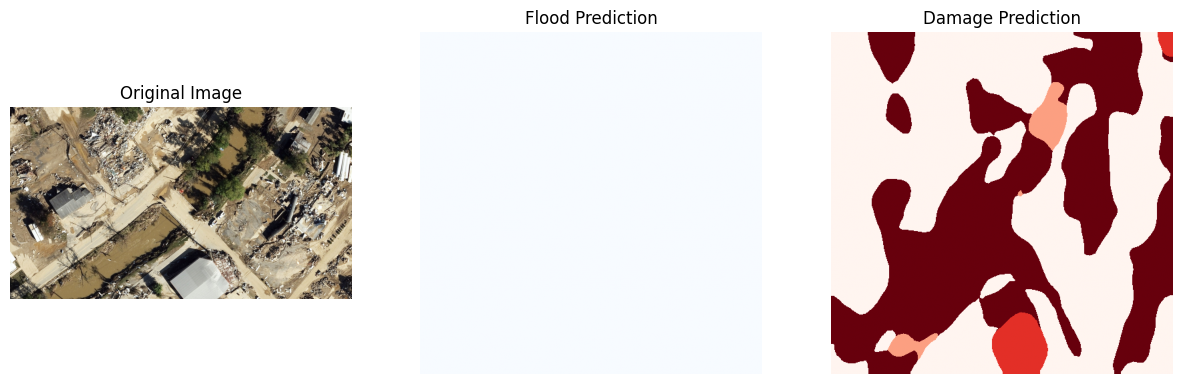

In [38]:
def test_on_new_image(model_path, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    checkpoint = torch.load(model_path,
                           map_location=device,
                           weights_only=False)

    # Create model instance
    model = EnhancedDisasterModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)  # Move model to device
    model.eval()

    # Process image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    transform = get_validation_augmentation()
    input_tensor = transform(image=image)['image']
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        flood_out, damage_out = model(input_tensor)

    flood_pred = torch.argmax(flood_out, dim=1)[0].cpu().numpy()
    damage_pred = torch.argmax(damage_out, dim=1)[0].cpu().numpy()

    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(flood_pred, cmap='Blues')
    axes[1].set_title('Flood Prediction')
    axes[1].axis('off')

    axes[2].imshow(damage_pred, cmap='Reds')
    axes[2].set_title('Damage Prediction')
    axes[2].axis('off')

    plt.show()
    return flood_pred, damage_pred

# Call it with a valid image path
flood_mask, damage_mask = test_on_new_image(
    '/content/checkpoints/best_model.pth',
    '/content/drive/MyDrive/G.E.M.S./Test Images/Hurricane-Helene-Asheville-NC_35.574034_-82.526808.jpg'
)

In [39]:
print(f"Flood pixels: {(flood_mask == 1).sum()}")
print(f"Damage distribution: {np.bincount(damage_mask.flatten())}")

Flood pixels: 262144
Damage distribution: [144573   5134   6657 105780]
